# Loan Prediction Project

This is a loan prediction project based on a dataset from Kaggle's [Loan Approval Prediction](https://www.kaggle.com/competitions/playground-series-s4e10/overview) competition.

## Project Background

The aim of this project is to use machine learning techniques to predict the approval status of loan applications. By analyzing and processing the data, we hope to build an accurate predictive model that can help financial institutions better assess loan risks.

## Data Source

The dataset is downloaded from Kaggle and includes both training and test sets, covering applicants' personal information, financial status, and details related to the loan application.

## Tools Used

- Python
- Jupyter Notebook
- Scikit-learn
- Pandas
- Matplotlib
- Seaborn
- XGBoost
- CatBoost

## Disclaimer

This project is for educational and research purposes only. The data is copyrighted by Kaggle and its providers.

# Import libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer,OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
import math
from sklearn.base import BaseEstimator, TransformerMixin
import optuna
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingRegressor
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, LogisticRegressionCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier, Pool
from xgboost import plot_importance
import re
import warnings
import gc

# Set seaborn style
sns.set_theme(style='darkgrid', font_scale=1.4)

# Initialize tqdm lock
tqdm_notebook.get_lock().locks = []

# Suppress warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## Read Kaggle API

In [37]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [38]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chilledwanker/loan-approval-prediction")

print("Path to dataset files:", path)

Path to dataset files: /Users/ellieyeung/.cache/kagglehub/datasets/chilledwanker/loan-approval-prediction/versions/1


# 2. Read data

In [39]:
test = pd.read_csv('~/my_kaggle_project/test.csv')
train = pd.read_csv('~/my_kaggle_project/train.csv')
original= pd.read_csv('/Users/ellieyeung/.cache/kagglehub/datasets/chilledwanker/loan-approval-prediction/versions/1/credit_risk_dataset.csv')

In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [42]:
train_copy=train.copy()
test_copy=test.copy()

target ='loan_status'

train.head()


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


The original data needs to be concatenated with the train data to integrate new data (original data) into the existing training dataset, expanding its size or updating its content, thereby improving the model's training performance. Additionally, removing duplicates (drop_duplicates) after concatenation ensures data cleanliness and uniqueness, avoiding potential biases caused by duplicate entries.

In [43]:
train = pd.concat([train, original], axis=0).drop_duplicates()

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91061 entries, 0 to 32580
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  float64
 1   person_age                  91061 non-null  int64  
 2   person_income               91061 non-null  int64  
 3   person_home_ownership       91061 non-null  object 
 4   person_emp_length           90174 non-null  float64
 5   loan_intent                 91061 non-null  object 
 6   loan_grade                  91061 non-null  object 
 7   loan_amnt                   91061 non-null  int64  
 8   loan_int_rate               87966 non-null  float64
 9   loan_percent_income         91061 non-null  float64
 10  cb_person_default_on_file   91061 non-null  object 
 11  cb_person_cred_hist_length  91061 non-null  int64  
 12  loan_status                 91061 non-null  int64  
dtypes: float64(4), int64(5), object(4)
m

1. Fill Missing Values:
It fills missing values in train['person_emp_length'] and train['loan_int_rate'] with 'missiong' and 'missing', respectively. This is done to handle missing data and prevent issues in further analysis.
2. Calculate Proportions:
It calculates the percentage of each category in train['loan_status'] by dividing the value counts by the total length of the dataset and multiplying by 100. This helps to understand the distribution of loan statuses in the dataset.

In [45]:
train.isna().sum()

id                            32416
person_age                        0
person_income                     0
person_home_ownership             0
person_emp_length               887
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_int_rate                  3095
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
loan_status                       0
dtype: int64

In [46]:
train['person_emp_length']= train['person_emp_length'].fillna('missiong')
train['loan_int_rate']= train['loan_int_rate'].fillna('missing')

In [47]:
(train['loan_status'].value_counts()/len(train))*100

loan_status
0    83.045431
1    16.954569
Name: count, dtype: float64

# 3. EDA

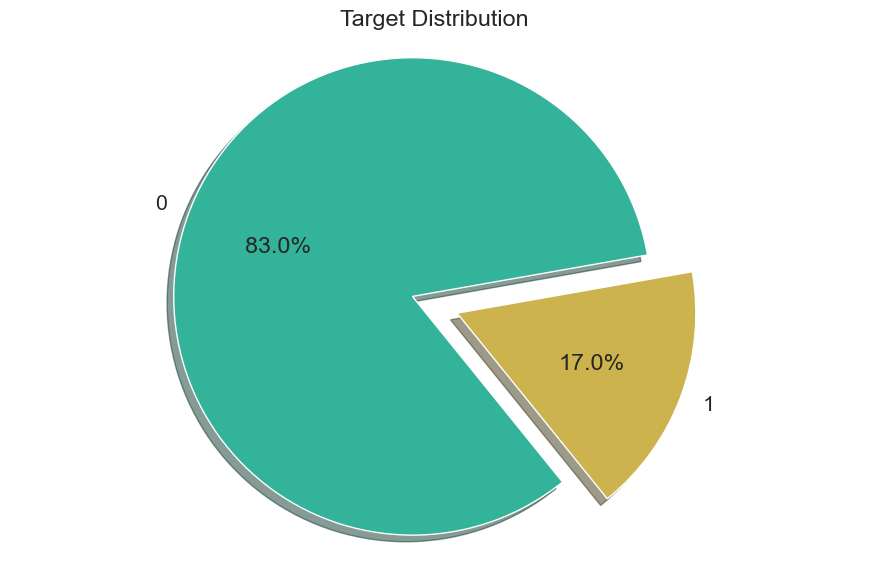

In [48]:
def plot_pie_chart(data, target, title, ax):
    data_counts = data[target].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [(0.2, 0.7, 0.6), (0.8, 0.7, 0.3)]
    explode = [0.1] * len(labels)  # Create an explode list with the same length as the number of labels

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=10)
    ax.axis('equal') 
    ax.set_title(title)

fig, ax = plt.subplots(figsize=(9, 6))  # Create a single subplot with specified size

plot_pie_chart(train, "loan_status", "Target Distribution", ax)

plt.tight_layout()
plt.show()


In [49]:
target_df=train['loan_status']
data_df =train.drop(["loan_status"], axis=1)

In [50]:
# Adjust the sampling strategy as needed
oversampler_df = RandomOverSampler(sampling_strategy=0.5)
oversampled_data, oversampled_target = oversampler_df.fit_resample(data_df, target_df)

undersampler_df = RandomUnderSampler(sampling_strategy=0.8)
undersampled_data, undersampled_target = undersampler_df.fit_resample(oversampled_data, oversampled_target)

In [51]:
undersampled_target.value_counts()

loan_status
0    47263
1    37811
Name: count, dtype: int64

In [52]:
train= pd.concat([undersampled_data,undersampled_target], axis=1)

# Categorical Feature Analysis

In [53]:
train.dtypes

id                            float64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length              object
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                  object
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [54]:
train.drop(columns=['id'],inplace=True)

In [55]:
train.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length              object
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                  object
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

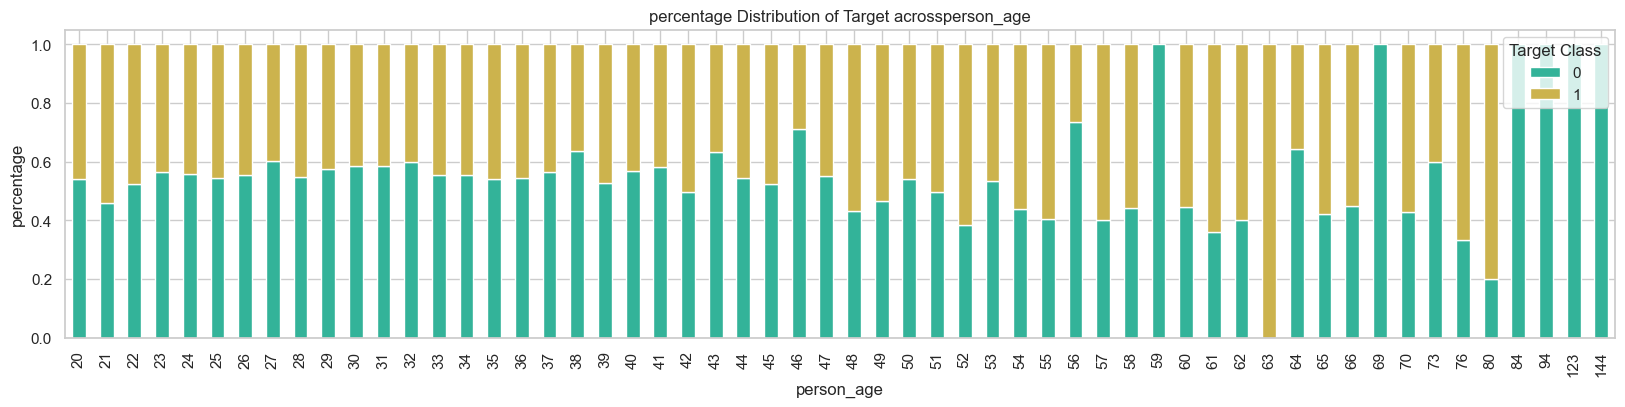

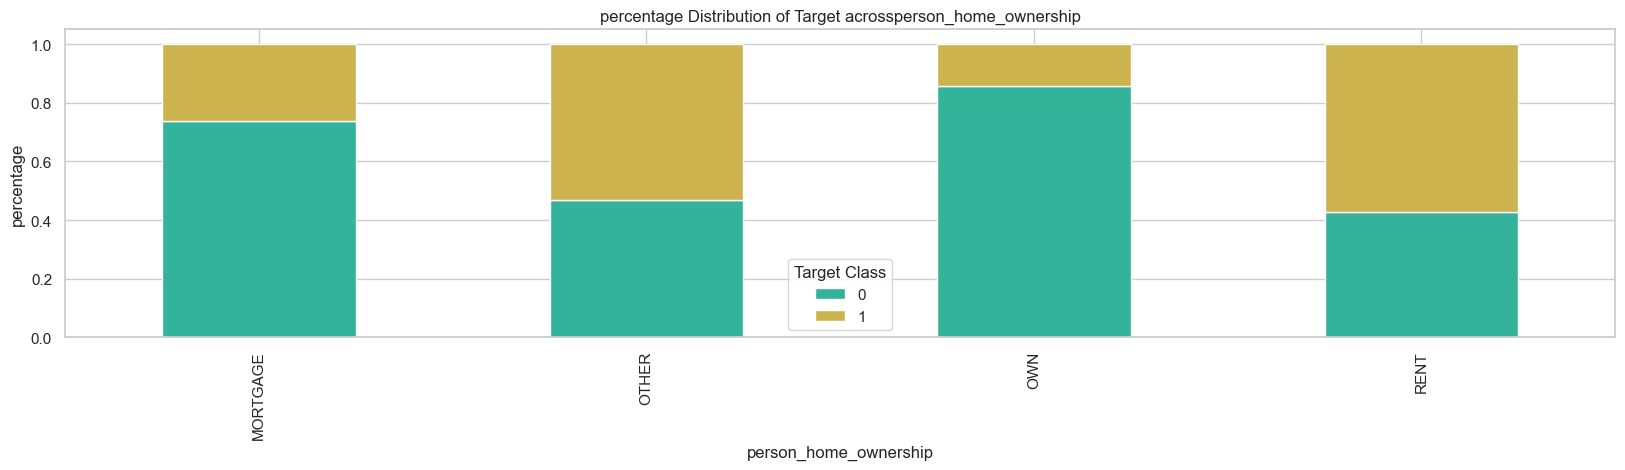

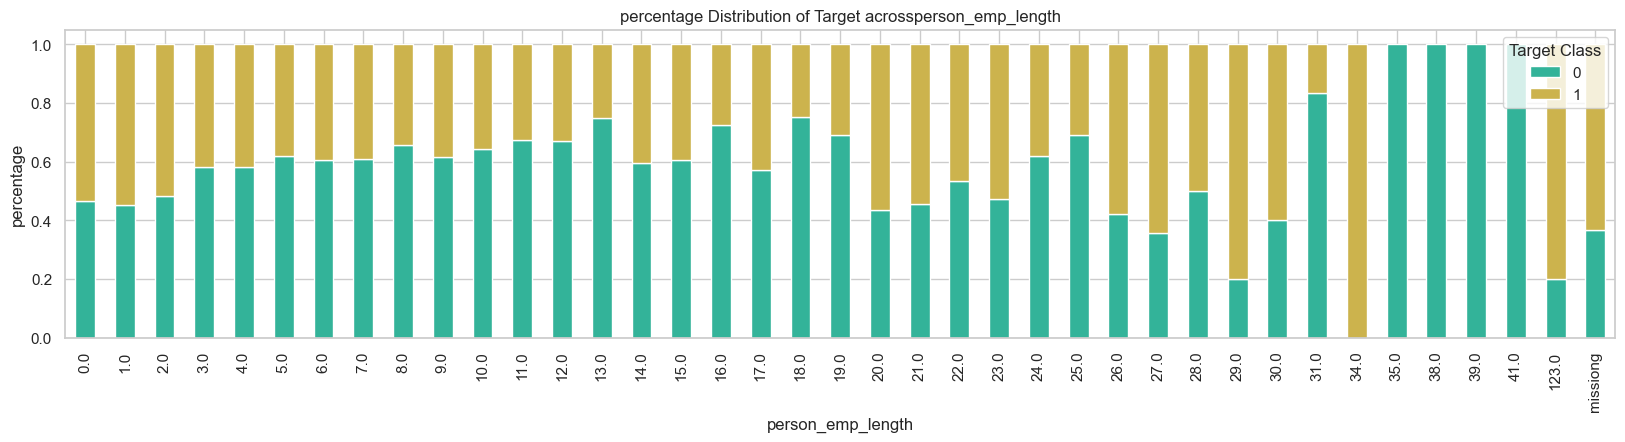

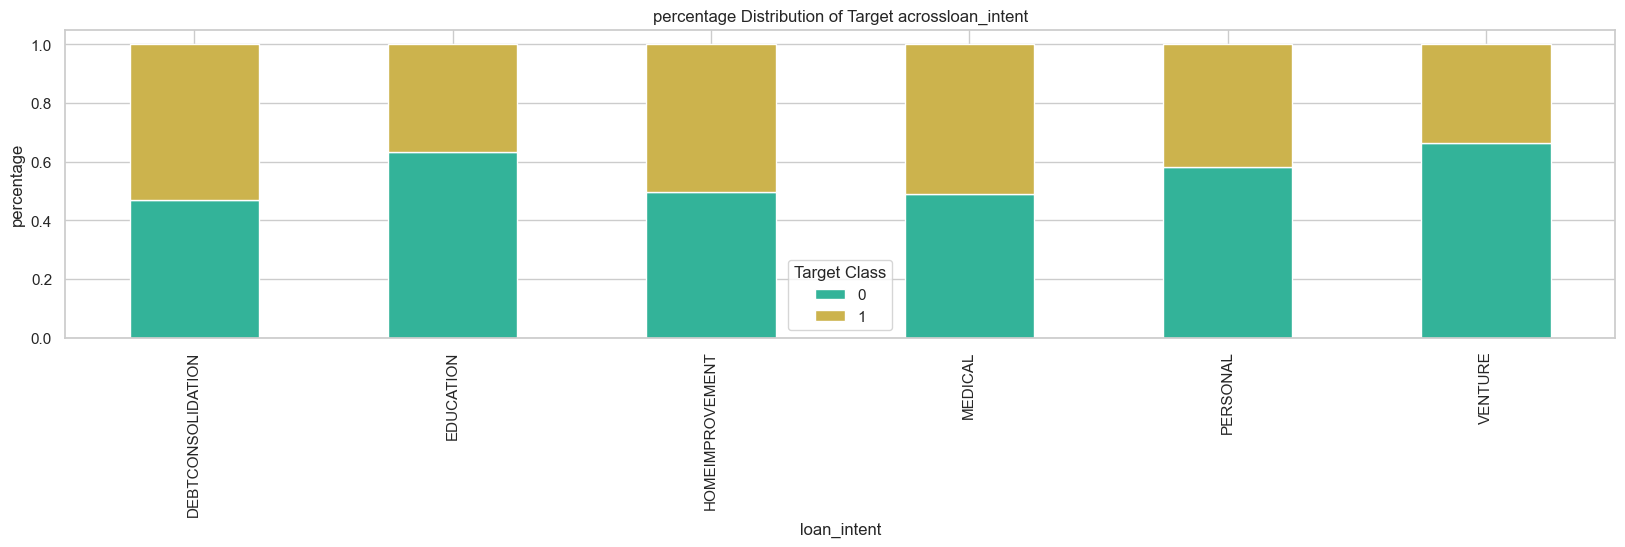

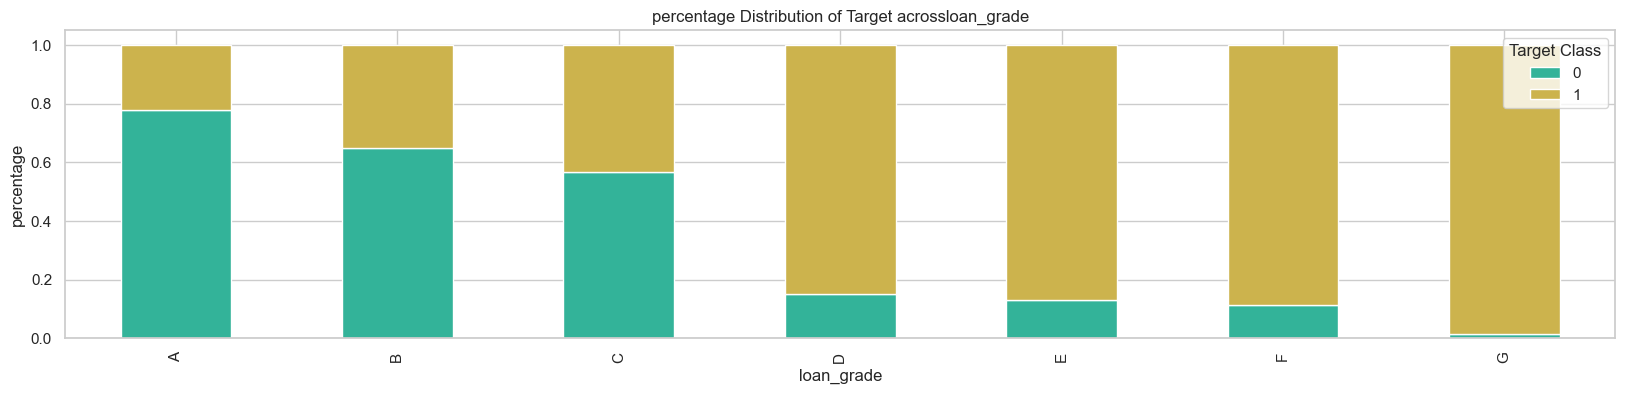

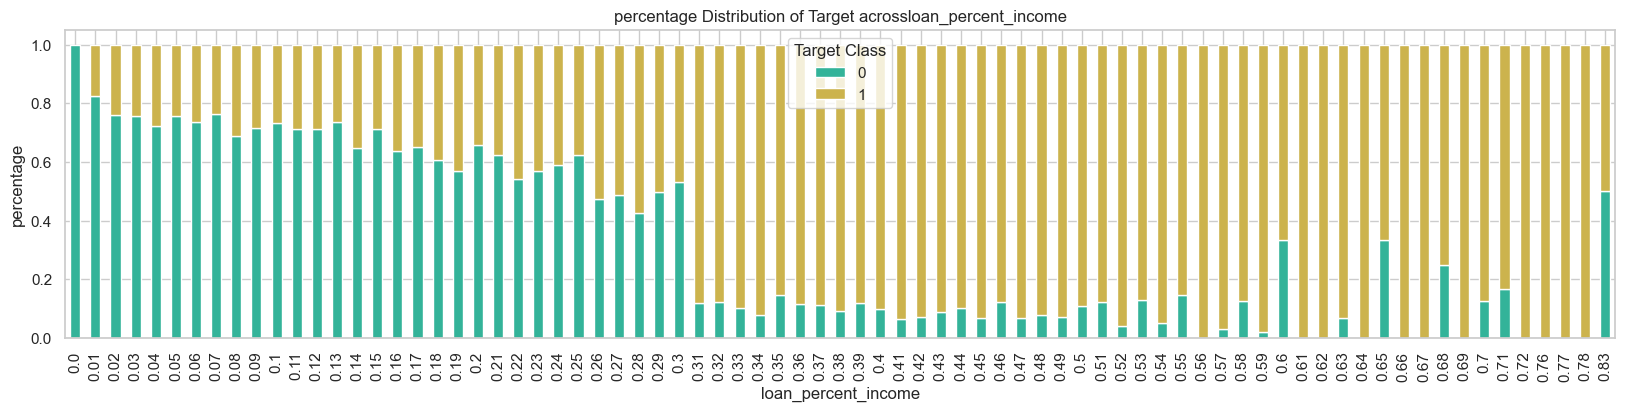

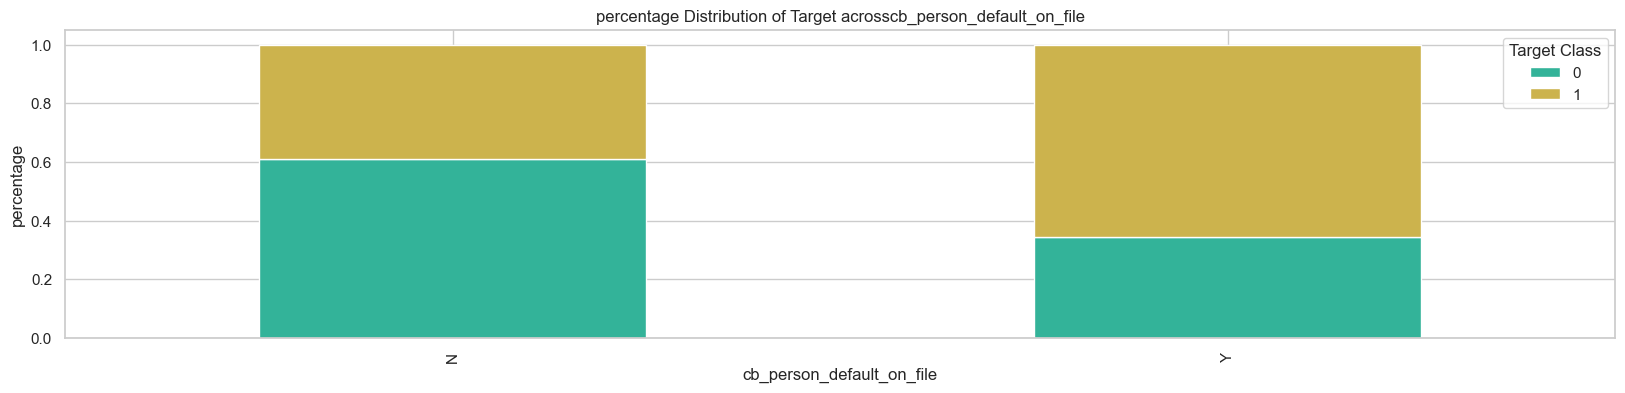

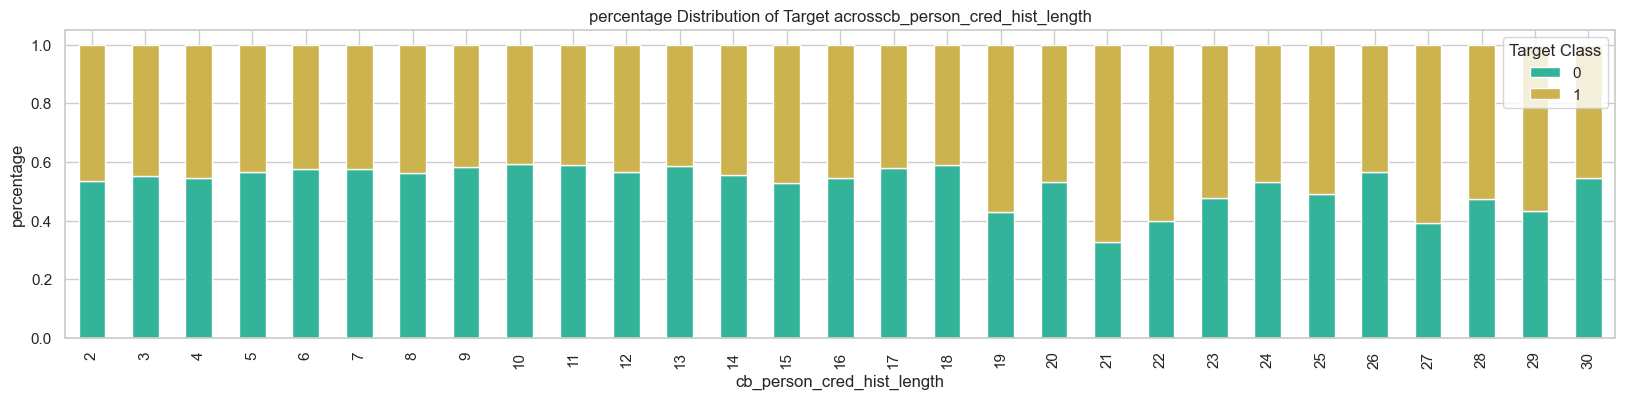

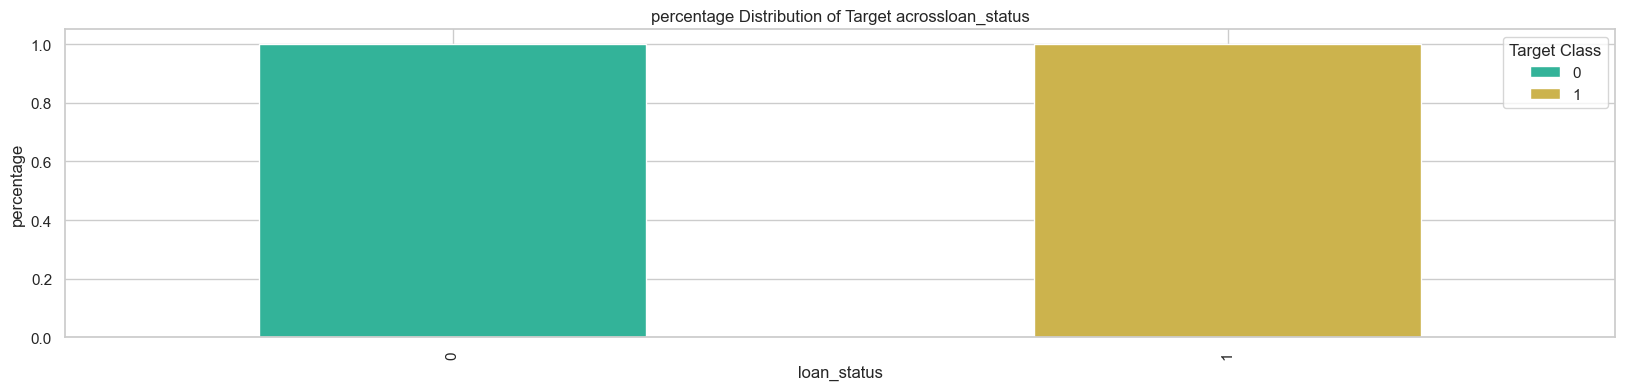

In [56]:
cat_cols = [f for f in train.columns if (train[f].dtype != '0' 
and train[f].nunique()<100) 
or train[f].dtype =='0' and f not in[target]]
custom_palette =(0.2, 0.7, 0.6),(0.8,0.7,0.3)
for col in cat_cols:
    contingency_table = pd.crosstab(train[col], train[target], normalize='index')
    sns.set(style='whitegrid')
    contingency_table.plot(kind='bar', stacked=True,color=custom_palette,figsize=(20,4))
    plt.title(f"percentage Distribution of Target across{col}")
    plt.xlabel(col)
    plt.ylabel("percentage")
    plt.legend(title="Target Class")
    plt.show()


1. The dataset imbalanced 87% vs 13% ,Balancing a dataset makes training a model easier because it helps prevent the model from becoming biased towards one class.

2. Person Aged between 35 and 60 have no status loan except ages 40 ,43 and 50

3. We see in the feature "Person_home_ownership" only mortgage and rent who hass status loan this is make sense

4. The relation between Loan percent income and our targe ,i think is strong because we see when persons have more income the statue loan increa

In [57]:
train['loan_status'].corr(train['loan_percent_income'])

0.42848409944652716

In [58]:
correlation_matrix = train.select_dtypes(np.number).corr()
print(correlation_matrix['loan_status'])

person_age                   -0.011623
person_income                -0.239491
loan_amnt                     0.162458
loan_percent_income           0.428484
cb_person_cred_hist_length   -0.012849
loan_status                   1.000000
Name: loan_status, dtype: float64


<Axes: >

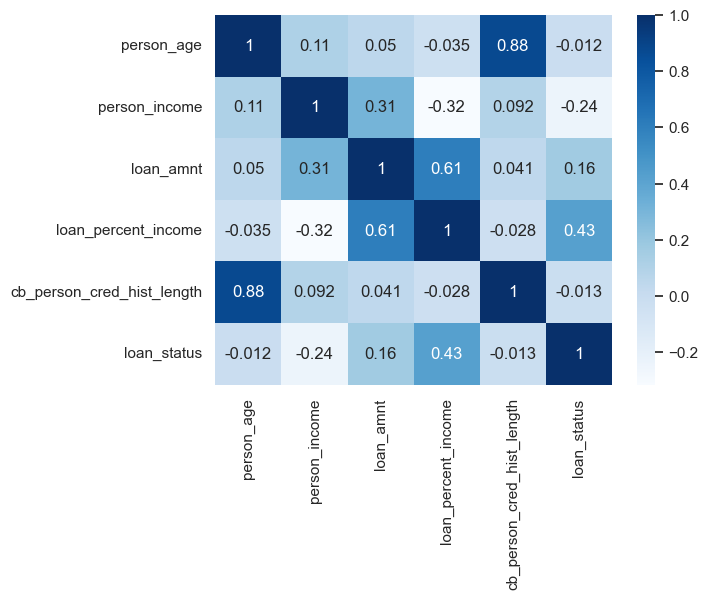

In [59]:
sns.heatmap(correlation_matrix, annot=True, cmap="Blues")

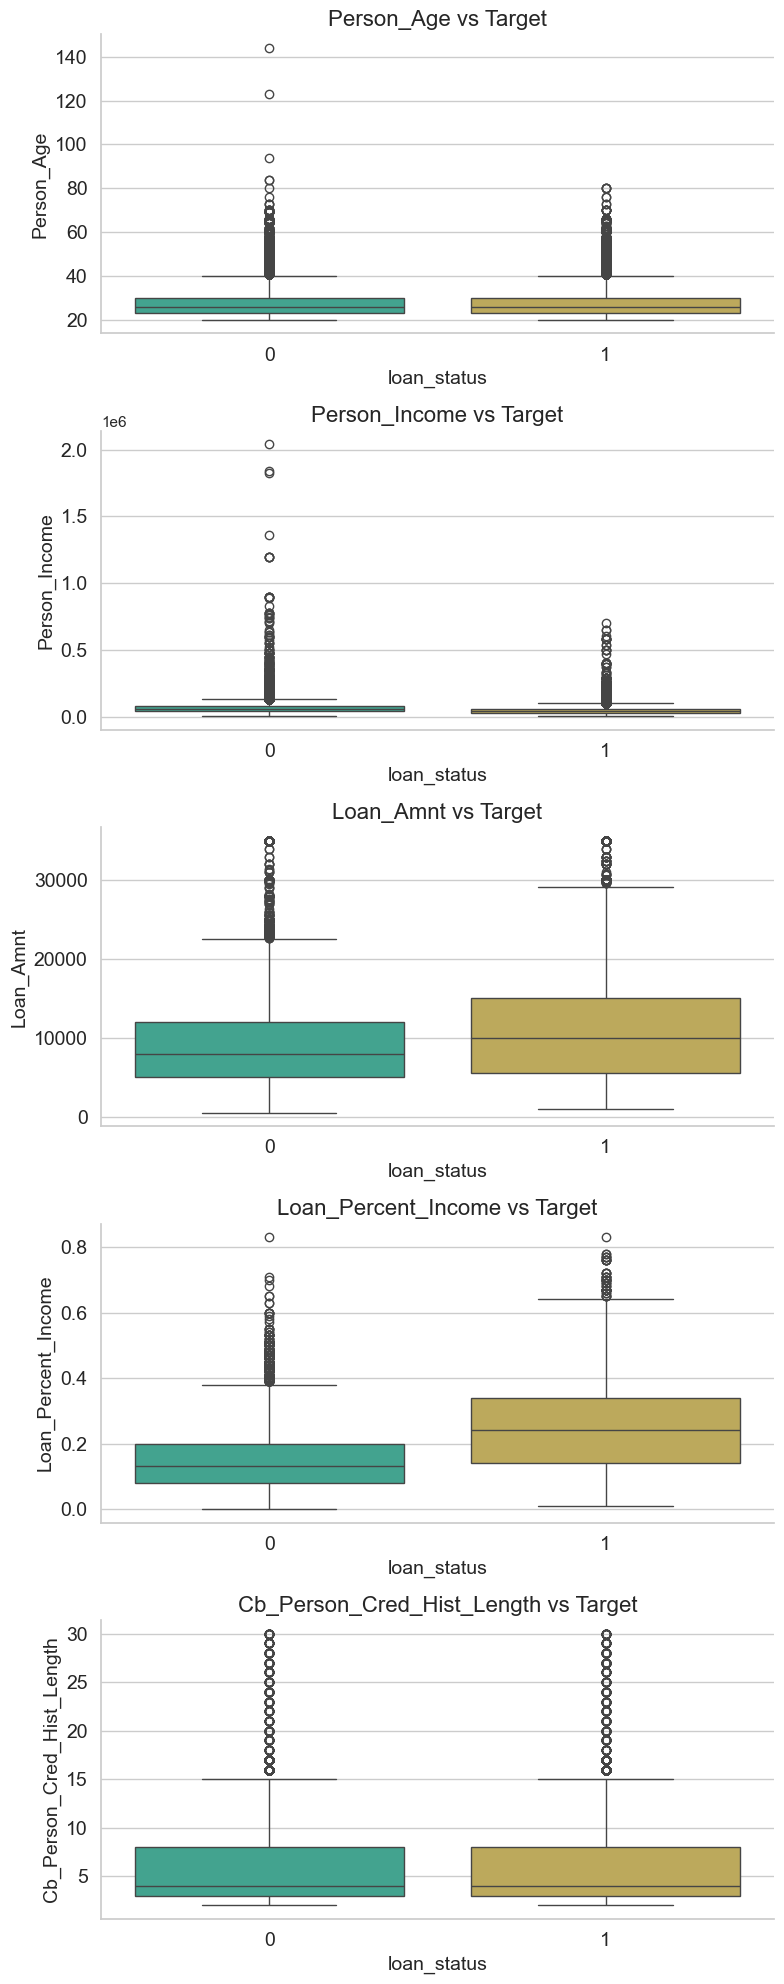

In [60]:
palette = [mcolors.to_rgba((0.2, 0.7, 0.6)), mcolors.to_rgba((0.8, 0.7, 0.3))]

cont_cols = [f for f in train.columns if train[f].dtype!='O' and f not in [target]]  

fig, axs = plt.subplots(nrows=len(cont_cols), figsize=(8, 4 * len(cont_cols)))
for i, col in enumerate(cont_cols):
    sns.boxplot(x=target, y=col, data=train, ax=axs[i], palette=palette)
    axs[i].set_title(f'{col.title()} vs Target', fontsize=16)
    axs[i].set_xlabel(target, fontsize=14)
    axs[i].set_ylabel(col.title(), fontsize=14)
    axs[i].tick_params(axis='both', labelsize=14)
    sns.despine()

fig.tight_layout()
plt.show()


# Drop outliers

In [61]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [62]:
from collections import Counter
num_cols = train.select_dtypes(include=np.number).columns.tolist()
# detecting outliers
Outliers_IQR = IQR_method(train,1,num_cols)

# dropping outliers
train = train.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 0


#  Feature Engineering

In [63]:
def feature_engineering(df_):  
    df = df_.copy()
    df['loantoincome'] = (df['loan_amnt'] / df['person_income']) - df['loan_percent_income']
    df['person_income'] = np.log(df['person_income'])
    return df

train, test = feature_engineering(train), feature_engineering(test)

# train_fe.drop_duplicates(inplace=True, ignore_index=True)


In [64]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoding_maps = {}
    
    def fit(self, X, y=None):
        """
        Learns the frequency mappings for the specified columns.

        Args:
        X (pd.DataFrame): Training DataFrame.
        y: Ignored (for compatibility with scikit-learn).

        Returns:
        self
        """    

        for column in X.columns:
            freq_encoding = X[column].value_counts() / len(X)
            self.encoding_maps[column] = freq_encoding.to_dict()
        return self

    def transform(self, X):
        """
        Applies frequency encoding to the columns of the DataFrame.

        Args:
        X (pd.DataFrame): DataFrame to transform.

        Returns:
        pd.DataFrame: Transformed DataFrame.
        """
        X_transformed = X.copy()
        for column in X.columns:
            encoding_map = self.encoding_maps.get(column, {})
            X_transformed[column] = X_transformed[column].map(lambda x: encoding_map.get(x, -1))
        return X_transformed

In [65]:
y=train['loan_status']
X=train.drop('loan_status',axis=1)


In [66]:
# Encoding by frequency
cat_features=X.select_dtypes(exclude=np.number).columns.tolist()
encoder = FrequencyEncoder()
encoder.fit(X[cat_features])
X[cat_features] = encoder.transform(X[cat_features])
test[cat_features] = encoder.transform(test[cat_features])
print('Encoding done!')

Encoding done!


In [67]:
final_features=[f for f in train.columns if f not in [target]]
final_features=[*set(final_features)]

sc=StandardScaler()

X[final_features]=sc.fit_transform(X[final_features])
test[final_features]=sc.transform(test[final_features])

# Train Model

In [69]:
test= test.drop('id', axis=1)

In [70]:
print("X columns:", X.columns)
if 'loan_status' in X.columns:
    X = X.drop(columns=['loan_status'])

X columns: Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loantoincome'],
      dtype='object')


In [71]:
# Define Numeric and Categorical Features
numeric_features = ['person_age', 'person_income', 'loan_amnt']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade']

#Preprocessing for Numeric Features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with mean
    ('scaler', StandardScaler())  # Standardize numeric features
])

# Preprocessing for Categorical Features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Fill missing values with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot encode
])

# Combine Preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply Preprocessing to Training and Test Data
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

aucs = []
preds = []
oof_pred = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_processed, y)):
    print(f"### Fold {fold+1} Training ###")

    # Training Loop with Cross-Validation
    X_train, X_valid = X_processed[train_idx], X_processed[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    X_test = test_processed

    # Model Definition
    xgb_optuna_params = {
        'n_estimators': 1696,
        'alpha': 4.95675218263538e-07,
        'subsample': 0.7349948172684618,
        'colsample_bytree': 0.30171411525842506,
        'max_depth': 15,
        'min_child_weight': 6,
        'learning_rate': 0.01331072238797047,
        'gamma': 5.634602153104516e-08
    }
    
    model = XGBClassifier(**xgb_optuna_params, random_state=42)
    
    # train the model
    model.fit(X_train, y_train)
    
    # validation prediction
    pred_valid = model.predict_proba(X_valid)[:, 1]
    preds.append(model.predict_proba(X_test)[:, 1])
    pred_valid_test = model.predict(X_test)
    oof_pred.append(pred_valid_test)
    
    # calculate auc
    auc = roc_auc_score(y_valid, pred_valid)
    aucs.append(auc)
    print(f"Fold {fold+1} AUC: {auc:.5f}")

    # memory cleanup
    gc.collect()

print(f'\nOverall AUC: {np.mean(aucs):.5f} +/- {np.std(aucs):.5f}')

### Fold 1 Training ###
Fold 1 AUC: 0.91389
### Fold 2 Training ###
Fold 2 AUC: 0.91501
### Fold 3 Training ###
Fold 3 AUC: 0.91677
### Fold 4 Training ###
Fold 4 AUC: 0.91400
### Fold 5 Training ###
Fold 5 AUC: 0.91441

Overall AUC: 0.91481 +/- 0.00105


<Figure size 1000x800 with 0 Axes>

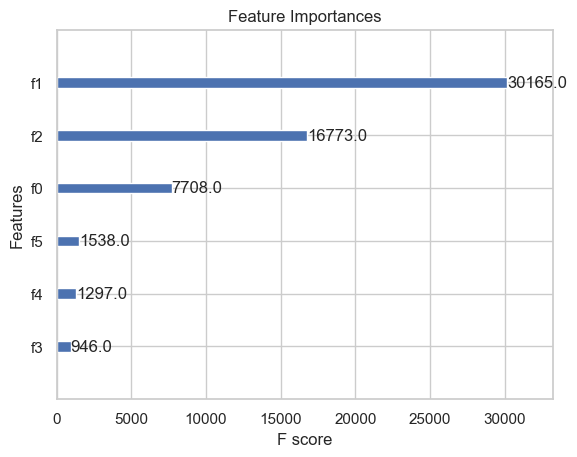

In [72]:
# draw the feature importance plot
plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='weight')  
plt.title("Feature Importances")
plt.show()

In [73]:
print("Trained Model:")
print(model)

Trained Model:
XGBClassifier(alpha=4.95675218263538e-07, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.30171411525842506, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5.634602153104516e-08,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01331072238797047,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1696, n_jobs=None,
              num_parallel_tree=None, ...)


In [74]:
# Final Test Predictions
final_test_preds = np.mean(preds, axis=0)
print("Final Test Predictions:")
print(final_test_preds[:10])  

Final Test Predictions:
[0.9957927  0.07226539 0.89448225 0.11327813 0.71108294 0.9787259
 0.00712208 0.03949163 0.75433975 0.08339722]
